In [251]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [252]:
 class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)
#         print("init_GConv_initialzing in_channels,outchannels and agg=add")

    def forward(self, x, edge_index):
#         print("forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A")
        # Step 1: Add self-loops
#         print(x.size());
#         print(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
#         print(edge_index)

        # Step 2: Multiply with weights
#         print(x.size());
        x = self.lin(x) # torch.Size([2708, 1433]) ---> torch.Size([2708, 16]) --> and in next call torch.Size([2708, 16]) --> torch.Size([2708, 7])
#         print(x.size());
#         print(x);

        # Step 3: Calculate the normalization
        row, col = edge_index
        #row,col are 1-d array from where to where node connections row-from, col-to which node
#         print(row)
#         print(col)
        deg = degree(row, x.size(0), dtype=x.dtype)
#         print(deg.size()) # 2708
        deg_inv_sqrt = deg.pow(-0.5)
#         print(deg_inv_sqrt)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
#         print(norm)

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
#         print("msg_taking normalized A and multiplying with x_j")
#         print(x_j)
#         print((norm.view(-1, 1)))
#         print((norm.view(-1, 1) * x_j).size())# torch.Size([13264, 16]) ---> torch.Size([13264, 7])
        return norm.view(-1, 1) * x_j
    


In [253]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
#         print("here at self.conv1")
        self.conv1 = GCNConv(dataset.num_node_features, 16)
#         print("here at self.conv2")
        self.conv2 = GCNConv(16, dataset.num_classes)
#         print("_init_net_initilizing model and making channels 1st 1433--> 16 and 2nd 16 --> 7")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
#         print("here at self.conv1 taking x and edge, index")
#         print(x)
#         print(x.size())
        x = self.conv1(x, edge_index)
#         print(x)
#         print(x.size())
#         print("now applying linear function relu")
        x = F.relu(x)
#         print(x)
#         print(x.size())
#         print("avoiding overfitting by dropping terms")
        x = F.dropout(x, training=self.training)
#         print("here at self.conv2 taking x and edge, index")
#         print(x)
#         print(x.size())
        x = self.conv2(x, edge_index)
#         print("forw_net_")

        return F.log_softmax(x, dim=1)

In [275]:
def plot_dataset(dataset):
    print("plot_dataset")
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
#     pos = nx.spring_layout(G)
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
#     nx.draw_networkx_edges(G,pos, width=2, alpha=0.7, edge_color='black')
    plt.show()

In [276]:
def test(data, train=True):
#     print("test")
#     print("here10")
    model.eval()#In PyTorch, the model.eval() method is used to switch the model into evaluation mode. When you call model.eval()

    correct = 0
#     print("here11")
    pred = model(data).max(dim=1)[1] #torch.Size([2708])
#     print(pred)# tensor([3, 3, 3,  ..., 3, 3, 3]) ---> tensor([3, 4, 4,  ..., 5, 3, 3])
#     print(pred.size())
#     print("here12")
    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))

plot_dataset


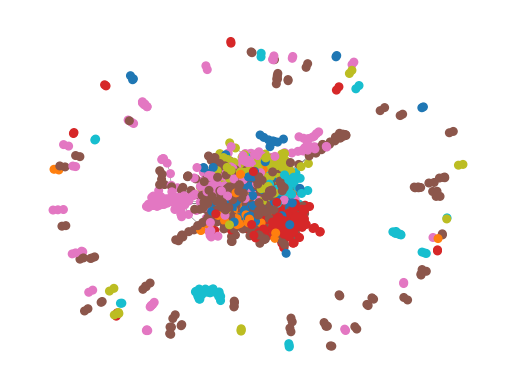

here1-creating model by Net(dataset)
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
train
tensor(1.9524, grad_fn=<NllLossBackward0>)
Epoch: 000, Loss: 1.95237, Train Acc: 0.32143, Test Acc: 0.27500
tensor(1.9051, grad_fn=<NllLossBackward0>)
Epoch: 001, Loss: 1.90511, Train Acc: 0.57143, Test Acc: 0.44800
tensor(1.8249, grad_fn=<NllLossBackward0>)
Epoch: 002, Loss: 1.82491, Train Acc: 0.62857, Test Acc: 0.43500
tensor(1.7447, grad_fn=<NllLossBackward0>)
Epoch: 003, Loss: 1.74475, Train Acc: 0.72143, Test Acc: 0.44200
tensor(1.6547, grad_fn=<NllLossBackward0>)
Epoch: 004, Loss: 1.65466, Train Acc: 0.80000, Test Acc: 0.50200
tensor(1.5496, grad_fn=<NllLossBackward0>)
Epoch: 005, Loss: 1.54957, Train Acc: 0.84286, Test Acc: 0.57000
tensor(1.4558, grad_fn=<NllLossBackward0>)
Epoch: 006, Loss: 1.45579, Train Acc: 0.91429, Test Acc: 0.63400
tensor(1.3103, grad_fn=<NllLossBackward0>)
Epoch: 007, Loss: 1.31031, Train Acc: 0.95000, Tes

Epoch: 077, Loss: 0.04414, Train Acc: 1.00000, Test Acc: 0.80700
tensor(0.0474, grad_fn=<NllLossBackward0>)
Epoch: 078, Loss: 0.04745, Train Acc: 1.00000, Test Acc: 0.80400
tensor(0.0593, grad_fn=<NllLossBackward0>)
Epoch: 079, Loss: 0.05928, Train Acc: 1.00000, Test Acc: 0.80300
tensor(0.0593, grad_fn=<NllLossBackward0>)
Epoch: 080, Loss: 0.05934, Train Acc: 1.00000, Test Acc: 0.79800
tensor(0.0418, grad_fn=<NllLossBackward0>)
Epoch: 081, Loss: 0.04181, Train Acc: 1.00000, Test Acc: 0.79800
tensor(0.0525, grad_fn=<NllLossBackward0>)
Epoch: 082, Loss: 0.05247, Train Acc: 1.00000, Test Acc: 0.79500
tensor(0.0509, grad_fn=<NllLossBackward0>)
Epoch: 083, Loss: 0.05087, Train Acc: 1.00000, Test Acc: 0.79200
tensor(0.0412, grad_fn=<NllLossBackward0>)
Epoch: 084, Loss: 0.04118, Train Acc: 1.00000, Test Acc: 0.79300
tensor(0.0394, grad_fn=<NllLossBackward0>)
Epoch: 085, Loss: 0.03945, Train Acc: 1.00000, Test Acc: 0.79700
tensor(0.0391, grad_fn=<NllLossBackward0>)
Epoch: 086, Loss: 0.03907, T

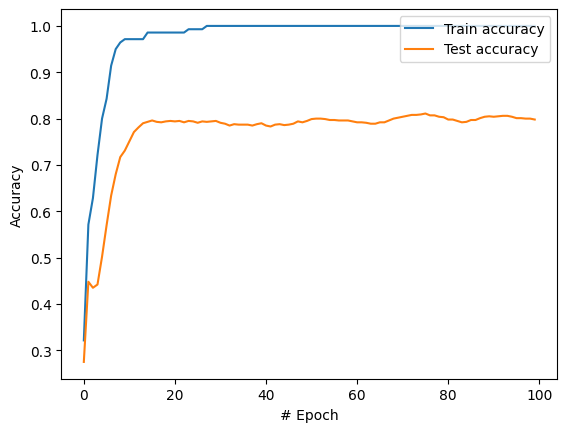

In [277]:
def train(data, plot=False):
    print("train")
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
#             print("here3-starting-model-training")
            model.train()
            optimizer.zero_grad()
#             print("here4-putting data in model")
            out = model(data)
#             print("here5 calculating loss")
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            print(loss) #tensor(1.9571, grad_fn=<NllLossBackward0>) --->  tensor(0.0413, grad_fn=<NllLossBackward0>)
#             print("here6 loss.backward()")
            loss.backward()
#             print("here7 optimizer.step()")
            optimizer.step()
            
#             print("here8-testing data and calculating training acc")
            train_acc = test(data)
#             print("here9-here8-testing data and calculating training acc")
            test_acc = test(data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Test accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()


if __name__ == "__main__":
#     print("start")
    dataset = Planetoid(root='tut', name='cora')
    
    plot_dataset(dataset)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("here1-creating model by Net(dataset)")
    model = Net(dataset).to(device)
#     print("here2 taking dataset[0]")
    data = dataset[0].to(device)
    print(dataset[0])
    #print(dataset)#cora()
#     only dataset[0] index present
#     print(dataset[])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    train(data, plot=True)

In [238]:
# start
# here1-creating model by Net(dataset)
# here at self.conv1
# init_GConv_initialzing in_channels,outchannels and agg=add
# here at self.conv2
# init_GConv_initialzing in_channels,outchannels and agg=add
# _init_net_initilizing model and making channels 1st 1433--> 16 and 2nd 16 --> 7
# here2 taking dataset[0]
# Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
# cora()
# train
# here3-starting-model-training
# here4-putting data in model
# here at self.conv1 taking x and edge, index
# tensor([[0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         ...,
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.]])
# torch.Size([2708, 1433])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 16])
# tensor([[-0.0534,  0.0683, -0.0091,  ...,  0.0064,  0.0375,  0.0075],
#         [-0.0105, -0.0014,  0.0234,  ..., -0.0879, -0.0231,  0.0055],
#         [-0.0046,  0.0532, -0.0183,  ..., -0.0589,  0.0088,  0.0049],
#         ...,
#         [-0.0292,  0.0320,  0.0069,  ..., -0.0239, -0.0644,  0.0128],
#         [-0.0411, -0.0230, -0.0015,  ...,  0.0090, -0.0300,  0.0359],
#         [-0.0225,  0.0002,  0.0002,  ...,  0.0062,  0.0148,  0.0470]],
#        grad_fn=<ScatterAddBackward0>)
# torch.Size([2708, 16])
# now applying linear function relu
# tensor([[0.0000, 0.0683, 0.0000,  ..., 0.0064, 0.0375, 0.0075],
#         [0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0055],
#         [0.0000, 0.0532, 0.0000,  ..., 0.0000, 0.0088, 0.0049],
#         ...,
#         [0.0000, 0.0320, 0.0069,  ..., 0.0000, 0.0000, 0.0128],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0090, 0.0000, 0.0359],
#         [0.0000, 0.0002, 0.0002,  ..., 0.0062, 0.0148, 0.0470]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# avoiding overfitting by dropping terms
# here at self.conv2 taking x and edge, index
# tensor([[0.0000, 0.1366, 0.0000,  ..., 0.0000, 0.0751, 0.0000],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
#         ...,
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
#         [0.0000, 0.0005, 0.0005,  ..., 0.0000, 0.0000, 0.0939]],
#        grad_fn=<MulBackward0>)
# torch.Size([2708, 16])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 7])
# forw_net_
# here5 calculating loss
# tensor(1.9571, grad_fn=<NllLossBackward0>)
# here6 loss.backward()
# here7 optimizer.step()
# here8-testing data and calculating training acc
# test
# here10
# here11
# here at self.conv1 taking x and edge, index
# tensor([[0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         ...,
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.]])
# torch.Size([2708, 1433])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 16])
# tensor([[-0.1218,  0.0983, -0.0814,  ..., -0.0519,  0.1588,  0.1583],
#         [-0.1991, -0.0252, -0.1383,  ..., -0.1412,  0.0358,  0.2135],
#         [-0.1441,  0.0117, -0.1493,  ..., -0.1109,  0.0806,  0.1843],
#         ...,
#         [-0.0492,  0.0726, -0.0731,  ..., -0.0240,  0.0356,  0.0930],
#         [-0.1184, -0.0003, -0.0679,  ..., -0.0396,  0.0804,  0.1886],
#         [-0.0835,  0.0062, -0.0401,  ..., -0.0406,  0.1067,  0.1755]],
#        grad_fn=<ScatterAddBackward0>)
# torch.Size([2708, 16])
# now applying linear function relu
# tensor([[0.0000, 0.0983, 0.0000,  ..., 0.0000, 0.1588, 0.1583],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0358, 0.2135],
#         [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0806, 0.1843],
#         ...,
#         [0.0000, 0.0726, 0.0000,  ..., 0.0000, 0.0356, 0.0930],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0804, 0.1886],
#         [0.0000, 0.0062, 0.0000,  ..., 0.0000, 0.1067, 0.1755]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# avoiding overfitting by dropping terms
# here at self.conv2 taking x and edge, index
# tensor([[0.0000, 0.0983, 0.0000,  ..., 0.0000, 0.1588, 0.1583],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0358, 0.2135],
#         [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0806, 0.1843],
#         ...,
#         [0.0000, 0.0726, 0.0000,  ..., 0.0000, 0.0356, 0.0930],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0804, 0.1886],
#         [0.0000, 0.0062, 0.0000,  ..., 0.0000, 0.1067, 0.1755]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 7])
# forw_net_
# tensor([3, 3, 3,  ..., 3, 3, 3])
# torch.Size([2708])
# here12
# here9-here8-testing data and calculating training acc
# test
# here10
# here11
# here at self.conv1 taking x and edge, index
# tensor([[0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         ...,
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.]])
# torch.Size([2708, 1433])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 16])
# tensor([[-0.1218,  0.0983, -0.0814,  ..., -0.0519,  0.1588,  0.1583],
#         [-0.1991, -0.0252, -0.1383,  ..., -0.1412,  0.0358,  0.2135],
#         [-0.1441,  0.0117, -0.1493,  ..., -0.1109,  0.0806,  0.1843],
#         ...,
#         [-0.0492,  0.0726, -0.0731,  ..., -0.0240,  0.0356,  0.0930],
#         [-0.1184, -0.0003, -0.0679,  ..., -0.0396,  0.0804,  0.1886],
#         [-0.0835,  0.0062, -0.0401,  ..., -0.0406,  0.1067,  0.1755]],
#        grad_fn=<ScatterAddBackward0>)
# torch.Size([2708, 16])
# now applying linear function relu
# tensor([[0.0000, 0.0983, 0.0000,  ..., 0.0000, 0.1588, 0.1583],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0358, 0.2135],
#         [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0806, 0.1843],
#         ...,
#         [0.0000, 0.0726, 0.0000,  ..., 0.0000, 0.0356, 0.0930],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0804, 0.1886],
#         [0.0000, 0.0062, 0.0000,  ..., 0.0000, 0.1067, 0.1755]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# avoiding overfitting by dropping terms
# here at self.conv2 taking x and edge, index
# tensor([[0.0000, 0.0983, 0.0000,  ..., 0.0000, 0.1588, 0.1583],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0358, 0.2135],
#         [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0806, 0.1843],
#         ...,
#         [0.0000, 0.0726, 0.0000,  ..., 0.0000, 0.0356, 0.0930],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0804, 0.1886],
#         [0.0000, 0.0062, 0.0000,  ..., 0.0000, 0.1067, 0.1755]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 7])
# forw_net_
# tensor([3, 3, 3,  ..., 3, 3, 3])
# torch.Size([2708])
# here12
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    

# here3-starting-model-training
# here4-putting data in model
# here at self.conv1 taking x and edge, index
# tensor([[0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         ...,
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.]])
# torch.Size([2708, 1433])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 16])
# tensor([[ 1.8652,  0.3090, -0.1343,  ...,  0.0775,  1.8920,  1.9554],
#         [-0.6193, -0.1298,  0.0374,  ...,  0.0316, -0.5467,  3.4055],
#         [-0.0238,  0.3332, -0.1538,  ...,  0.1611, -0.2938,  2.5571],
#         ...,
#         [ 1.4325,  0.4872,  0.4303,  ...,  1.1485,  1.1713,  0.8685],
#         [ 1.2395,  0.0695,  0.0075,  ..., -0.0747,  0.9073,  2.0946],
#         [ 1.2026, -0.0946, -0.0885,  ..., -0.3712,  0.8269,  1.6166]],
#        grad_fn=<ScatterAddBackward0>)
# torch.Size([2708, 16])
# now applying linear function relu
# tensor([[1.8652, 0.3090, 0.0000,  ..., 0.0775, 1.8920, 1.9554],
#         [0.0000, 0.0000, 0.0374,  ..., 0.0316, 0.0000, 3.4055],
#         [0.0000, 0.3332, 0.0000,  ..., 0.1611, 0.0000, 2.5571],
#         ...,
#         [1.4325, 0.4872, 0.4303,  ..., 1.1485, 1.1713, 0.8685],
#         [1.2395, 0.0695, 0.0075,  ..., 0.0000, 0.9073, 2.0946],
#         [1.2026, 0.0000, 0.0000,  ..., 0.0000, 0.8269, 1.6166]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# avoiding overfitting by dropping terms
# here at self.conv2 taking x and edge, index
# tensor([[3.7304, 0.6180, 0.0000,  ..., 0.1551, 0.0000, 0.0000],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
#         [0.0000, 0.6665, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
#         ...,
#         [0.0000, 0.9743, 0.0000,  ..., 2.2970, 0.0000, 0.0000],
#         [0.0000, 0.1391, 0.0000,  ..., 0.0000, 1.8147, 4.1892],
#         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.2331]],
#        grad_fn=<MulBackward0>)
# torch.Size([2708, 16])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 7])
# forw_net_
# here5 calculating loss
# tensor(0.0413, grad_fn=<NllLossBackward0>)
# here6 loss.backward()
# here7 optimizer.step()
# here8-testing data and calculating training acc
# test
# here10
# here11
# here at self.conv1 taking x and edge, index
# tensor([[0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         ...,
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.]])
# torch.Size([2708, 1433])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 16])
# tensor([[ 1.8596,  0.3050, -0.1253,  ...,  0.0898,  1.8783,  1.9549],
#         [-0.6261, -0.1289,  0.0545,  ...,  0.0504, -0.5645,  3.4082],
#         [-0.0298,  0.3353, -0.1419,  ...,  0.1765, -0.2988,  2.5603],
#         ...,
#         [ 1.4225,  0.4896,  0.4386,  ...,  1.1569,  1.1549,  0.8734],
#         [ 1.2316,  0.0694,  0.0166,  ..., -0.0635,  0.8957,  2.1047],
#         [ 1.1973, -0.0972, -0.0816,  ..., -0.3614,  0.8179,  1.6249]],
#        grad_fn=<ScatterAddBackward0>)
# torch.Size([2708, 16])
# now applying linear function relu
# tensor([[1.8596, 0.3050, 0.0000,  ..., 0.0898, 1.8783, 1.9549],
#         [0.0000, 0.0000, 0.0545,  ..., 0.0504, 0.0000, 3.4082],
#         [0.0000, 0.3353, 0.0000,  ..., 0.1765, 0.0000, 2.5603],
#         ...,
#         [1.4225, 0.4896, 0.4386,  ..., 1.1569, 1.1549, 0.8734],
#         [1.2316, 0.0694, 0.0166,  ..., 0.0000, 0.8957, 2.1047],
#         [1.1973, 0.0000, 0.0000,  ..., 0.0000, 0.8179, 1.6249]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# avoiding overfitting by dropping terms
# here at self.conv2 taking x and edge, index
# tensor([[1.8596, 0.3050, 0.0000,  ..., 0.0898, 1.8783, 1.9549],
#         [0.0000, 0.0000, 0.0545,  ..., 0.0504, 0.0000, 3.4082],
#         [0.0000, 0.3353, 0.0000,  ..., 0.1765, 0.0000, 2.5603],
#         ...,
#         [1.4225, 0.4896, 0.4386,  ..., 1.1569, 1.1549, 0.8734],
#         [1.2316, 0.0694, 0.0166,  ..., 0.0000, 0.8957, 2.1047],
#         [1.1973, 0.0000, 0.0000,  ..., 0.0000, 0.8179, 1.6249]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 7])
# forw_net_
# tensor([3, 4, 4,  ..., 5, 3, 3])
# torch.Size([2708])
# here12
# here9-here8-testing data and calculating training acc
# test
# here10
# here11
# here at self.conv1 taking x and edge, index
# tensor([[0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         ...,
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.],
#         [0., 0., 0.,  ..., 0., 0., 0.]])
# torch.Size([2708, 1433])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 16])
# tensor([[ 1.8596,  0.3050, -0.1253,  ...,  0.0898,  1.8783,  1.9549],
#         [-0.6261, -0.1289,  0.0545,  ...,  0.0504, -0.5645,  3.4082],
#         [-0.0298,  0.3353, -0.1419,  ...,  0.1765, -0.2988,  2.5603],
#         ...,
#         [ 1.4225,  0.4896,  0.4386,  ...,  1.1569,  1.1549,  0.8734],
#         [ 1.2316,  0.0694,  0.0166,  ..., -0.0635,  0.8957,  2.1047],
#         [ 1.1973, -0.0972, -0.0816,  ..., -0.3614,  0.8179,  1.6249]],
#        grad_fn=<ScatterAddBackward0>)
# torch.Size([2708, 16])
# now applying linear function relu
# tensor([[1.8596, 0.3050, 0.0000,  ..., 0.0898, 1.8783, 1.9549],
#         [0.0000, 0.0000, 0.0545,  ..., 0.0504, 0.0000, 3.4082],
#         [0.0000, 0.3353, 0.0000,  ..., 0.1765, 0.0000, 2.5603],
#         ...,
#         [1.4225, 0.4896, 0.4386,  ..., 1.1569, 1.1549, 0.8734],
#         [1.2316, 0.0694, 0.0166,  ..., 0.0000, 0.8957, 2.1047],
#         [1.1973, 0.0000, 0.0000,  ..., 0.0000, 0.8179, 1.6249]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# avoiding overfitting by dropping terms
# here at self.conv2 taking x and edge, index
# tensor([[1.8596, 0.3050, 0.0000,  ..., 0.0898, 1.8783, 1.9549],
#         [0.0000, 0.0000, 0.0545,  ..., 0.0504, 0.0000, 3.4082],
#         [0.0000, 0.3353, 0.0000,  ..., 0.1765, 0.0000, 2.5603],
#         ...,
#         [1.4225, 0.4896, 0.4386,  ..., 1.1569, 1.1549, 0.8734],
#         [1.2316, 0.0694, 0.0166,  ..., 0.0000, 0.8957, 2.1047],
#         [1.1973, 0.0000, 0.0000,  ..., 0.0000, 0.8179, 1.6249]],
#        grad_fn=<ReluBackward0>)
# torch.Size([2708, 16])
# forward_gconv_adding self loops,lowering dimension of x using the channels,normalizing A
# msg_taking normalized A and multiplying with x_j
# tensor([[0.2500],
#         [0.2236],
#         [0.2500],
#         ...,
#         [0.5000],
#         [0.2000],
#         [0.2000]])
# torch.Size([13264, 7])
# forw_net_
# tensor([3, 4, 4,  ..., 5, 3, 3])
# torch.Size([2708])
# here12